In [1]:
import xarray as xr
import numpy as np
import os
import arrow
import json
import time
import pandas as pd
import datetime
import metpy.calc as mpcalc
from metpy.units import units
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'tensorflow'

In [71]:
import matplotlib as mpl
# mpl.use("cairo")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter

In [76]:
timeStrList = ['000', '003', '006', '009', '012', '015', '018', '021', '024', '027', '030', '033', '036', '039', '042', '045', '048', '051', '054', '057', '060', '063', '066', '069', '072', '078', '084', '090',
               '096', '102', '108', '114', '120', '126', '132', '138', '144', '150', '156', '162', '168', '174', '180', '186', '192', '198', '204', '210', '216', '222', '228', '234', '240', ]
fcHour_list = list(range(0, 72+1, 3)) + list(range(78, 240+1, 6))

config = {
    'sstk':{
        'name':'sstk',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'valid_min': 273.16,
        'standard_name': 'sea_surface_skin_temperature',
        'units': 'K',
        'long_name': 'sea surface temperature',
        'short_name': 'SST',
    },
    'visi':{
        'name':'visi',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'valid_min': 0.0,
        'standard_name': 'visibility_in_air',
        'units': 'm',
        'long_name': 'visibility',
        'short_name': 'visibility',
    },
    't2md':{
        'name':'t2md',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'valid_min': 0.0,
        'standard_name': 'dew_point_temperature',
        'units': 'K',
        'long_name': 'dew point',
        'short_name': 'Td',
    },
    't2mm':{
        'name':'t2mm',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'valid_min': 0.0,
        'standard_name': 'air_temperature',
        'units': 'K',
        'long_name': 'air temperature in 2 metre',
        'short_name': 'T2m',
    },
    'sktk':{
        'name':'sktk',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'valid_min': 0.0,
        'standard_name': 'surface_temperature',
        'units': 'K',
        'long_name': 'surface temperature',
        'short_name': 'sktk',
    },
    'mn2t':{
        'name':'mn2t',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'valid_min': 0.0,
        'standard_name': 'air_temperature',
        'units': 'K',
        'long_name': 'air temperature minimum in 2 metre since 6 hr before',
        'short_name': 'T2m',
    },
    'mx2t':{
        'name':'mx2t',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'valid_min': 0.0,
        'standard_name': 'air_temperature',
        'units': 'K',
        'long_name': 'air temperature maxium in 2 metre since 6 hr before',
        'short_name': 'T2m',
    },
    'rhum':{
        'name':'rhum',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'valid_min': 0.0,
        'standard_name': 'relative_humidity',
        'units': '0.01',
        'long_name': 'relative_humidity',
        'short_name': 'RH',
    },
    'temp':{
        'name':'temp',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'valid_min': 0.0,
        'standard_name': 'air_temperature',
        'units': 'K',
        'long_name': 'air temperature',
        'short_name': 'Temp',
    },
    'uwnd':{
        'name':'uwnd',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'standard_name': 'eastward_wind',
        'units': 'm/s',
        'long_name': 'u wind',
        'short_name': 'Uwnd',
    },
    'vwnd':{
        'name':'vwnd',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'standard_name': 'northward_wind',
        'units': 'm/s',
        'long_name': 'v wind',
        'short_name': 'Vwnd',
    },
    'u10m':{
        'name':'u10m',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'standard_name': 'eastward_wind',
        'units': 'm/s',
        'long_name': 'u wind',
        'short_name': 'Uwnd',
    },
    'v10m':{
        'name':'v10m',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'standard_name': 'northward_wind',
        'units': 'm/s',
        'long_name': 'v wind',
        'short_name': 'Vwnd',
    },
    'u100':{
        'name':'u100',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'standard_name': 'eastward_wind',
        'units': 'm/s',
        'long_name': 'u wind',
        'short_name': 'Uwnd',
    },
    'v100':{
        'name':'v100',
        'missing_value': -999.9,
        # '_FillValue':  -999.9,
        'standard_name': 'northward_wind',
        'units': 'm/s',
        'long_name': 'v wind',
        'short_name': 'Vwnd',
    },
}

In [198]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(np.isnan(x)):
      y = np.nan
    elif(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

def setDataset(df, x_columns):
    df['t_td'] =  df['t2mm'] - df['t2md']
    df['td_sst'] =  df['t2md'] - df['sstk']
    df['t_sst'] =  df['t2mm'] - df['sstk']
    df['delta_theta'] = df['theta925'] - df['theta1000']
    df['delta_theta_e'] = df['theta_e925'] - df['theta_e1000']
    df_x = df.loc[:, x_columns]
    df_y = df['station_vis_linear']
    _x = df_x.to_numpy()
    _y = df_y.to_numpy()
    return (_x, _y)

In [3]:
dir_path = 'H:/data/ec_thin/'
var_symbols = [
't2md',
't2mm',
'sstk',
'u100',
'v100',
'u10m',
'v10m',
'rhum',
'temp',]


In [4]:
# ds_list = []
# for iSymbol in var_symbols:
#     i_dataset = xr.open_dataset(f'{dir_path}{iSymbol}.nc')
#     ds_list.append(i_dataset)

ds_list = []
for iSymbol in var_symbols:
    i_dataset = xr.open_dataset(f'http://10.148.8.71:7080/thredds/dodsC/ecmwfthin/202210/{iSymbol}.nc')
    ds_list.append(i_dataset)

In [5]:
area = [105, 125, 15, 28]
da_test = ds_list[3]['u100024']
# print(da_test)
da_test.sel(time = da_test.time[0].values)

<xarray.DataArray 'u100024' (level: 1, lat: 561, lon: 2880)>
[1615680 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 0.125 0.25 0.375 0.5 ... 359.5 359.6 359.8 359.9
  * lat      (lat) float32 -10.0 -9.875 -9.75 -9.625 ... 59.62 59.75 59.88 60.0
  * level    (level) float32 0.0
    time     datetime64[ns] 2022-10-01

In [6]:
time_step = '024'
area = [105, 125, 15, 28]
da_list = []
for iSymbol, i_ds in zip(var_symbols, ds_list):
    i_dataArray = i_ds[f'{iSymbol}{time_step}']
    print(iSymbol)
    if iSymbol == 'rhum' or iSymbol == 'temp':
        sud_dataArray = i_dataArray.sel(time=i_dataArray.time[0].values, level=[1000.0, 925.0], lat=slice(area[2], area[3]), lon=slice(area[0], area[1]))
    else:
        sud_dataArray = i_dataArray.sel(time=i_dataArray.time[0].values, level=0.0, lat=slice(area[2], area[3]), lon=slice(area[0], area[1]))
    da_list.append(sud_dataArray)



t2md
t2mm
sstk
u100
v100
u10m
v10m
rhum
temp


In [7]:
(t2md, t2mm,sstk,u100,v100,u10m,v10m,rhum,temp) = da_list

In [86]:
sstk = xr.where(sstk>273.16, sstk, np.nan)

In [30]:
print(rhum)

<xarray.DataArray 'rhum024' (level: 2, lat: 53, lon: 81)>
array([[[96.049126, 92.549126, ..., 79.049126, 75.049126],
        [94.549126, 92.549126, ..., 78.549126, 77.549126],
        ...,
        [83.049126, 80.549126, ..., 84.049126, 81.549126],
        [93.549126, 87.049126, ..., 84.549126, 81.049126]],

       [[99.498184, 98.498184, ..., 93.498184, 92.998184],
        [99.498184, 98.498184, ..., 93.498184, 93.998184],
        ...,
        [82.998184, 80.998184, ..., 83.998184, 83.498184],
        [93.498184, 86.498184, ..., 87.498184, 83.998184]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 105.0 105.2 105.5 105.8 ... 124.2 124.5 124.8 125.0
  * lat      (lat) float32 15.0 15.25 15.5 15.75 16.0 ... 27.25 27.5 27.75 28.0
  * level    (level) float32 1e+03 925.0
    time     datetime64[ns] 2022-10-01


In [230]:
iTime = pd.Timestamp(t2md.time.dt.date.values.item())  + pd.Timedelta(24,unit='h')
year_sin = np.sin((iTime.dayofyear / 365.25) * 2 * np.pi)
year_cos = np.cos((iTime.dayofyear / 365.25) * 2 * np.pi)
day_sin = np.sin((iTime.hour / 24) * 2 * np.pi)
day_cos = np.cos((iTime.hour / 24) * 2 * np.pi)
print(year_sin, year_cos, day_sin, day_cos)

-0.999832969770105 0.018276557681691223 0.0 1.0


In [9]:
temp.shape

(2, 53, 81)

In [10]:
rhum_unit = np.clip(rhum, 0, 100)*units.percent
temp_unit = temp*units.kelvin
td_upper = mpcalc.dewpoint_from_relative_humidity(temp_unit, rhum_unit)

_x, level_mesh, _z = np.meshgrid(temp.lat, temp.level,temp.lon)
level_mesh = np.array(level_mesh)*units.hPa
theta_e = mpcalc.equivalent_potential_temperature(level_mesh, temp_unit, td_upper)
theta = mpcalc.potential_temperature(level_mesh, temp_unit)
theta_e = theta_e.metpy.convert_units('degC')
theta = theta.metpy.convert_units('degC')
print(theta_e)


<xarray.DataArray (level: 2, lat: 53, lon: 81)>
<Quantity([[[78.6026   78.53525  79.74249  ... 81.50897  81.95941  81.10321 ]
  [79.08856  78.24948  78.58316  ... 81.245636 81.74356  80.887085]
  [78.64548  78.0004   78.74225  ... 80.9487   81.429535 80.739685]
  ...
  [93.39929  91.862274 89.30914  ... 76.8248   77.14114  76.16571 ]
  [93.73312  90.188324 88.94571  ... 77.113434 76.935486 75.89676 ]
  [91.90082  89.29764  89.007355 ... 77.29501  76.701935 75.579865]]

 [[78.46161  77.17966  77.454315 ... 78.89252  79.664185 80.07892 ]
  [78.46161  77.72977  77.618805 ... 79.733765 79.664185 80.29477 ]
  [78.37463  78.39194  77.89398  ... 80.015015 80.08453  80.57669 ]
  ...
  [85.40427  83.40671  81.4205   ... 67.82391  68.460785 68.35693 ]
  [85.238434 82.50644  81.27893  ... 67.40573  68.6651   68.239136]
  [82.92325  80.85257  80.90384  ... 68.948456 69.74277  68.310394]]], 'degree_Celsius')>
Coordinates:
  * lon      (lon) float32 105.0 105.2 105.5 105.8 ... 124.2 124.5 124.8 125.

In [14]:
def interpolate(dataArray,  resolution:float = 0.125 ):
    lons = np.arange(dataArray.lon[0], dataArray.lon[-1]+resolution, resolution)
    lats = np.arange(dataArray.lat[0], dataArray.lat[-1]+resolution, resolution) 
    newDa = dataArray.interp(lon=lons, lat=lats, method="linear")
    return newDa

In [19]:
theta_e_interp = interpolate(theta_e)
theta_interp = interpolate(theta)

In [17]:
theta_e_interp.lon

<xarray.DataArray 'lon' (lon: 161)>
array([105.   , 105.125, 105.25 , 105.375, 105.5  , 105.625, 105.75 , 105.875,
       106.   , 106.125, 106.25 , 106.375, 106.5  , 106.625, 106.75 , 106.875,
       107.   , 107.125, 107.25 , 107.375, 107.5  , 107.625, 107.75 , 107.875,
       108.   , 108.125, 108.25 , 108.375, 108.5  , 108.625, 108.75 , 108.875,
       109.   , 109.125, 109.25 , 109.375, 109.5  , 109.625, 109.75 , 109.875,
       110.   , 110.125, 110.25 , 110.375, 110.5  , 110.625, 110.75 , 110.875,
       111.   , 111.125, 111.25 , 111.375, 111.5  , 111.625, 111.75 , 111.875,
       112.   , 112.125, 112.25 , 112.375, 112.5  , 112.625, 112.75 , 112.875,
       113.   , 113.125, 113.25 , 113.375, 113.5  , 113.625, 113.75 , 113.875,
       114.   , 114.125, 114.25 , 114.375, 114.5  , 114.625, 114.75 , 114.875,
       115.   , 115.125, 115.25 , 115.375, 115.5  , 115.625, 115.75 , 115.875,
       116.   , 116.125, 116.25 , 116.375, 116.5  , 116.625, 116.75 , 116.875,
       117.   , 117.125, 117.25 , 117.375, 117.5  , 117.625, 117.75 , 117.875,
       118.   , 118.125, 118.25 , 118.375, 118.5  , 118.625, 118.75 , 118.875,
       119.   , 119.125, 119.25 , 119.375, 119.5  , 119.625, 119.75 , 119.875,
       120.   , 120.125, 120.25 , 120.375, 120.5  , 120.625, 120.75 , 120.875,
       121.   , 121.125, 121.25 , 121.375, 121.5  , 121.625, 121.75 , 121.875,
       122.   , 122.125, 122.25 , 122.375, 122.5  , 122.625, 122.75 , 122.875,
       123.   , 123.125, 123.25 , 123.375, 123.5  , 123.625, 123.75 , 123.875,
       124.   , 124.125, 124.25 , 124.375, 124.5  , 124.625, 124.75 , 124.875,
       125.   ])
Coordinates:
    time     datetime64[ns] 2022-10-01
  * lon      (lon) float64 105.0 105.1 105.2 105.4 ... 124.6 124.8 124.9 125.0
Attributes:
    units:    degrees_east

In [21]:
os.environ['COMPUTERNAME']

'H1809-P014'

In [23]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
elif  os.environ['COMPUTERNAME'] == 'H1809-P014':
  computer_flag = 'office'
else:
  computer_flag = 'office2'


if computer_flag == 'home':
  root_dir = "F:/github/pythonScript/seafog/"
else:
  root_dir = "H:/github/python/seafog/"

In [87]:
fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/hdf/fog_dataset_hdf66_fc120h_v2.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
df_valid_test = store_dataset.get('valid_test')
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e','theta_e925']

(train_x, train_y) = setDataset(df_train, x_columns)
(valid_x, valid_y) = setDataset(df_valid, x_columns)
(test_x,  test_y)  = setDataset(df_test, x_columns)
(valid_test_x, valid_test_y) = setDataset(df_valid_test, x_columns)



print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.transform(valid_x)
valid_test_x_scaled = scaler.transform(valid_test_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]
    valid_test_x_scaled[:,index]  = valid_test_x[:,index]

['/test', '/train', '/valid', '/valid_test']
(469269, 17)
(469269,)


In [122]:
train_x[:,2]

array([-8.19717407, -0.75378418, -0.95080566, ...,  3.40359497,
       -3.66430664, -1.84567261])

In [123]:
df_train['t_sst']

440236   -8.197174
201956   -0.753784
182830   -0.950806
28555     0.381805
377472   -1.759003
            ...   
35470    -2.062683
289749   -0.477173
418130    3.403595
243929   -3.664307
394751   -1.845673
Name: t_sst, Length: 469269, dtype: float32

In [30]:
scaler = StandardScaler()
train_x_scaled_fit = scaler.fit(train_x)
print(train_x_scaled_fit.scale_)
print(train_x_scaled_fit.mean_)
print(train_x_scaled_fit.var_)

[ 1.97833201  4.09911624  3.26444358  4.18354527  3.25615019  3.37824326
  2.70599268  3.95002623  3.99820856  4.90342882  0.67624848  0.6251678
  0.65930821  0.71423223  1.73999737  4.97796997 13.24905271]
[ 2.58056535 -1.88579295  0.6947724  -0.18032674 -0.52429002 -4.54404442
 -3.5676635  22.93255603 20.35199067 22.23778363  0.08341111  0.38065181
 -0.15661821  0.17508784  3.33270731 -3.04193444 62.84389222]
[  3.91379754  16.80275392  10.65659191  17.50205102  10.60251407
  11.41252755   7.32239637  15.60270724  15.98567166  24.04361415
   0.457312     0.39083478   0.43468731   0.51012767   3.02759086
  24.78018501 175.53739782]


In [24]:
model = tf.keras.models.load_model(os.path.normpath(os.path.join(root_dir, './data/model/model_singletest_fog_dataset_hdf66_fc120h_v2')))

In [ ]:
# TODO apply_ufunc测试 https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html
# TODO 加载fog_dataset_hdf66_fc120h_v2.h5
# TODO 转换实时数据为标准格式
# TODO 测试自定义标准化和transform有何区别

In [88]:
t_td = t2mm - t2md
td_sst = t2md - sstk
t_sst = t2mm - sstk
delta_theta = theta_interp.sel(level=925.0) - theta_interp.sel(level=1000.0)
delta_theta_e = theta_e_interp.sel(level=925.0) - theta_e_interp.sel(level=1000.0)
theta_e925 = theta_e_interp.sel(level=925.0)

In [182]:
t2mm = t2mm -273.16
t2md = t2md -273.16
sstk = sstk -273.16


In [126]:
print(t_sst)

<xarray.DataArray (lat: 105, lon: 161)>
array([[        nan,         nan,         nan, ..., -1.4803467 ,
        -1.1971436 , -1.0057373 ],
       [        nan,         nan,         nan, ..., -1.5408936 ,
        -1.2908936 , -1.3221436 ],
       [        nan,         nan,         nan, ..., -1.3153076 ,
        -1.3328857 , -1.3826904 ],
       ...,
       [        nan,         nan,         nan, ..., -0.2947998 ,
        -0.42956543, -0.7244873 ],
       [        nan,         nan,         nan, ..., -0.32019043,
        -0.34069824, -0.430542  ],
       [        nan,         nan,         nan, ..., -0.36608887,
        -0.25964355, -0.24401855]], dtype=float32)
Coordinates:
  * lon      (lon) float32 105.0 105.1 105.2 105.4 ... 124.6 124.8 124.9 125.0
  * lat      (lat) float32 15.0 15.12 15.25 15.38 ... 27.62 27.75 27.88 28.0
    level    float32 0.0
    time     datetime64[ns] 2022-10-01


In [89]:
t_td_stack = t_td.stack(z=("lat","lon"))
td_sst_stack = td_sst.stack(z=("lat","lon"))
t_sst_stack = t_sst.stack(z=("lat","lon"))
print(t_td_stack)

<xarray.DataArray (z: 16905)>
array([0.90625, 0.90625, 1.65625, ..., 3.28125, 3.78125, 4.     ],
      dtype=float32)
Coordinates:
    level    float32 0.0
    time     datetime64[ns] 2022-10-01
  * z        (z) MultiIndex
  - lat      (z) float64 15.0 15.0 15.0 15.0 15.0 ... 28.0 28.0 28.0 28.0 28.0
  - lon      (z) float64 105.0 105.1 105.2 105.4 ... 124.6 124.8 124.9 125.0


In [35]:
t_td_stack.values.shape

(16905,)

In [183]:
stack_list = [t_td, td_sst, t_sst, v100, v10m, u100, u10m, t2mm, t2md, sstk,delta_theta,delta_theta_e,theta_e925]
one_dim_list = []
for arr in stack_list:
    stacked = arr.stack(z=("lat","lon"))
    one_dim_list.append(stacked.values)

In [184]:
year_sin_list = np.full_like(one_dim_list[0], year_sin)
year_cos_list = np.full_like(one_dim_list[0], year_cos)
day_sin_list = np.full_like(one_dim_list[0], day_sin)
day_cos_list = np.full_like(one_dim_list[0], day_cos)
time_list = [year_sin_list, year_cos_list, day_sin_list, day_cos_list]

In [107]:
len(one_dim_list[9:])

4

In [185]:
full_list = one_dim_list[:10] + time_list + one_dim_list[10:]

In [186]:
order_arr = np.array(full_list)
order_arr.shape


(17, 16905)

In [187]:
order_x = order_arr.T

In [95]:
order_x

array([[ 0.90625   ,         nan,         nan, ...,  3.44189453,
        -0.14099121, 78.46160889],
       [ 0.90625   ,         nan,         nan, ...,  3.13526917,
        -0.74829102, 77.82063293],
       [ 1.65625   ,         nan,         nan, ...,  2.8286438 ,
        -1.35559082, 77.17965698],
       ...,
       [ 3.28125   , -3.64733887, -0.36608887, ...,  1.67779541,
        -6.95916748, 69.74276733],
       [ 3.78125   , -4.04089355, -0.25964355, ...,  1.59274292,
        -7.11431885, 69.02658081],
       [ 4.        , -4.24401855, -0.24401855, ...,  1.50769043,
        -7.26947021, 68.31039429]])

In [96]:
order_x[:,0]

array([0.90625, 0.90625, 1.65625, ..., 3.28125, 3.78125, 4.     ])

In [188]:
order_x_scale = scaler.transform(order_x)

In [189]:
keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e']
x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e','theta_e925']
for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    order_x_scale[:,index] = order_x[:,index]


In [167]:
order_x_scale[:,1]

array([        nan,         nan,         nan, ..., -3.64733887,
       -4.04089355, -4.24401855])

In [168]:
x_columns[13]

'day_cos'

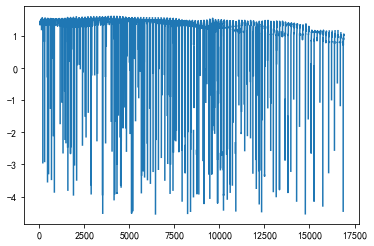

In [191]:
plt.plot(order_x_scale[:,9])
plt.show()
# ERROR index -> 7,8,9,13

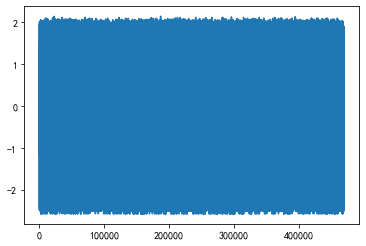

In [180]:
plt.plot(train_x_scaled[:,9])
plt.show()

In [192]:
predictions = model(order_x_scale).numpy()

In [132]:
model(test_x_scaled).numpy()

array([[1.4585195],
       [1.4730177],
       [1.4788129],
       ...,
       [2.5617461],
       [2.3556101],
       [1.6090164]], dtype=float32)

In [193]:
stack_sample = t_td.stack(z=("lat","lon"))

In [103]:
print(stack_sample.shape, predictions[:,0].shape)

(16905,) (16905,)


In [199]:
vis = np.vectorize(reverse_linear_vis)(predictions[:,0])

In [200]:
stack_sample.values = vis

In [201]:
prediction_vis = stack_sample.unstack("z")
print(prediction_vis)

<xarray.DataArray (lat: 105, lon: 161)>
array([[           nan,            nan,            nan, ...,
        15764.62268829, 15265.26451111, 14404.46376801],
       [           nan,            nan,            nan, ...,
        15178.87115479, 14936.14196777, 14293.53713989],
       [           nan,            nan,            nan, ...,
        15145.55454254, 14719.26689148, 14218.23501587],
       ...,
       [           nan,            nan,            nan, ...,
         7235.82696915,  7500.56314468,  7713.43183517],
       [           nan,            nan,            nan, ...,
         7946.39348984,  8115.81897736,  8001.37662888],
       [           nan,            nan,            nan, ...,
         8350.15070438,  8374.81307983,  7984.08281803]])
Coordinates:
    level    float32 0.0
    time     datetime64[ns] 2022-10-01
  * lat      (lat) float64 15.0 15.12 15.25 15.38 ... 27.62 27.75 27.88 28.0
  * lon      (lon) float64 105.0 105.1 105.2 105.4 ... 124.6 124.8 124.9 125.0


In [215]:
colordict_fog=['#6100BF','#8815D9','#AF30F2','#C340FF','#00014D','#0003BF','#0004FD','#2629FD','#2280F9','#6EB9F7','#59E144','#BBE7BB','#E6F5E6','#FFFEFF']
clrmap_fog = mcolors.ListedColormap(colordict_fog)
bound_fog = [0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.3, 2.1, 3.4, 5.5]
bound_fog = [0.,50.,200.,500.,1_000.,2_000.,3_000.,4_000.,6_000.,8_000.,10_000.,15_000.,20_000.,25_000.,30_000]
norms_fog = mcolors.BoundaryNorm(bound_fog, clrmap_fog.N)

<Figure size 432x288 with 0 Axes>

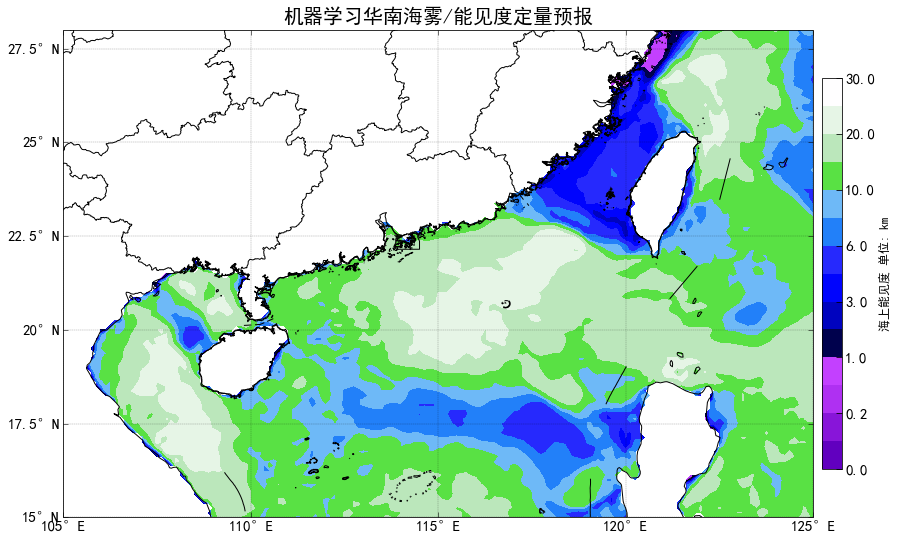

In [216]:
plt.clf()
lon=sstk.coords['lon'][:]#读取经度
lat=sstk.coords['lat'][:]#读取纬度
figure = plt.figure(figsize=(16, 9))  # 加载画布
fogMap = plt.axes(projection=ccrs.PlateCarree())  # 设置投影方式
shpFilePath01  = os.path.join(root_dir, './data/shapefiles/natural_earth/physical/ne_50m_coastline.shp')
coastmap = shpreader.Reader(shpFilePath01).geometries()  # 读取地图数据
fogMap.set_extent([105, 125, 15, 28], crs=ccrs.PlateCarree())  # 设置绘图范围
fogMap.add_geometries(coastmap, ccrs.PlateCarree(),
                          facecolor='none', edgecolor='black')  # 设置边界样式
shpFilePath02  = os.path.join(root_dir, './data/shapefiles/china_basic_map/bou2_4l.shp')
chinamap = shpreader.Reader(shpFilePath02).geometries()  # 读取地图数据
fogMap.set_extent([105, 125, 15, 28], crs=ccrs.PlateCarree())  # 设置绘图范围
fogMap.add_geometries(chinamap, ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black')  # 设置边界样式

fogMap.set_xticks([105, 110, 115, 120, 125])  # 需要显示的经度，一般可用np.arange
fogMap.set_yticks([15, 17.5, 20, 22.5, 25, 27.5])  # 需要显示的纬度
fogMap.xaxis.set_major_formatter(LongitudeFormatter())  # 将横坐标转换为经度格式
fogMap.yaxis.set_major_formatter(LatitudeFormatter())  # 将纵坐标转换为纬度格式
fogMap.tick_params(axis='both', labelsize=15, direction='in',
                   length=5, width=0.55, right=True, top=True)  # 修改刻度样式
fogMap.grid(linewidth=0.4, color='k', alpha=0.45, linestyle='--')  # 开启网格线

fogContourf = fogMap.contourf(lon, lat, prediction_vis, bound_fog,
                                    cmap=clrmap_fog, norm=norms_fog)
cb = figure.colorbar(fogContourf, extend='max', shrink=0.8, pad=0.01)
cb.set_label('海上能见度 单位: km', fontdict={'size': 12})
cb.ax.tick_params(which='major', direction='in', length=6, labelsize=15)
cb.ax.set_yticklabels(np.array(bound_fog)/1000.0)
fogMap.set_title(f'机器学习华南海上能见度定量预报', fontsize=20)
plt.show()